In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


In [5]:
score = pd.read_csv('LBLS467-data/score.csv')
srl_motivation = pd.read_csv('LBLS467-data/srl_motivation.csv')
sill = pd.read_csv('LBLS467-data/sill.csv')
srl_strategy = pd.read_csv('LBLS467-data/srl_strategy.csv')
br = pd.read_csv('LBLS467-data/br.csv')
viscode = pd.read_csv('LBLS467-data/viscode.csv')

In [6]:
br.head()

,Unnamed: 0,userid,ADD BOOKMARK,ADD MARKER,ADD MEMO,ADD_HW_MEMO,ADD_RECOMMENDATION,BOOKMARK_JUMP,CHANGE MEMO,CLEAR_HW_MEMO,...,OPEN,OPEN_RECOMMENDATION,PAGE_JUMP,PREV,REGIST CONTENTS,SEARCH,SEARCH_JUMP,UNDO_HW_MEMO,score,class
0,0,019acd030e0cdf674dda03e2a8ca4369,1,81,15,0,0,0,14,0,...,159,0,109,1584,0,0,0,0,70,h
1,1,01ea38c4c3cc5fba869732fc641ca884,7,354,36,1,0,2,22,1,...,256,0,67,750,0,1,0,2,80,a
2,2,023c88ec58c8cf0abcfbcea4166793ad,1,61,25,0,0,0,9,0,...,325,0,7,1275,0,0,0,0,90,a
3,3,02d679ad650962b6ae8bf8adbeeb33c1,4,188,28,8,0,4,25,0,...,138,0,40,788,0,0,0,0,56,c
4,4,0307ea84b89fceab3b507fec1900ce7e,43,464,48,1,0,116,214,0,...,415,0,80,2771,0,0,0,1,80,b


In [7]:
from functools import reduce

dfs = [score, srl_motivation, sill, srl_strategy, br]

def merge_keep_left(left, right):
    right = right[[col for col in right.columns if col not in left.columns or col == "userid"]]
    return pd.merge(left, right, on="userid", how="inner")

merged = reduce(merge_keep_left, dfs)


In [66]:
merged.columns

Index(['userid', 'score', 'class', 'srl_m_1', 'srl_m_2', 'srl_m_3', 'srl_m_4',
       'srl_m_5', 'srl_m_6', 'srl_m_7',
       ...
       'NEXT', 'NOTGETIT', 'OPEN', 'OPEN_RECOMMENDATION', 'PAGE_JUMP', 'PREV',
       'REGIST CONTENTS', 'SEARCH', 'SEARCH_JUMP', 'UNDO_HW_MEMO'],
      dtype='object', length=159)

In [67]:
len(merged)

204

In [8]:
X = merged.drop(["userid","class","score",'Unnamed: 0'], axis=1)  
y = merged["score"]

In [84]:
merged.corr(numeric_only=True)["score"].sort_values(ascending=False)

score                 1.000000
srl_m_19              0.425210
srl_m_23              0.396347
srl_m_24              0.356284
srl_m_22              0.354662
                        ...   
s_44                 -0.202610
srl_m_30             -0.228294
srl_m_27             -0.286955
ADD_RECOMMENDATION         NaN
REGIST CONTENTS            NaN
Name: score, Length: 157, dtype: float64

Fold 1 RMSE: 7.5409
Fold 2 RMSE: 9.4082
Fold 3 RMSE: 11.0611
Fold 4 RMSE: 11.3279
Fold 5 RMSE: 8.2718
Cross-validation RMSE scores: [np.float64(7.5408888248198345), np.float64(9.408205811171747), np.float64(11.061085406317666), np.float64(11.327863957042752), np.float64(8.271810072469027)]
Mean RMSE: 9.521970814364204


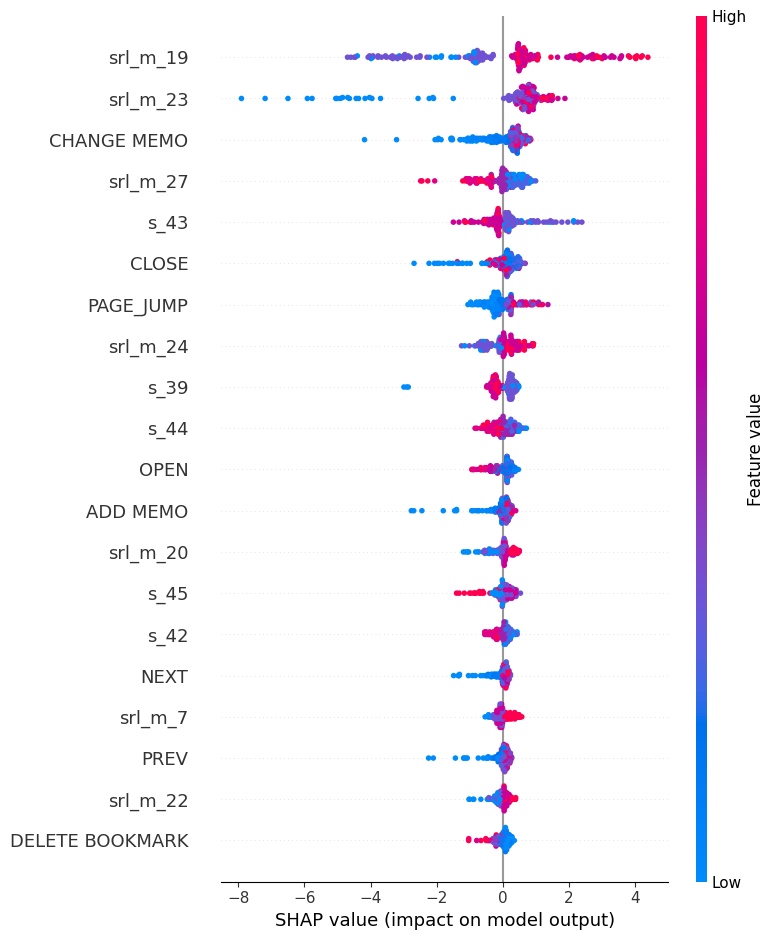

In [85]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt

# 初始化
rf = RandomForestRegressor(n_estimators=200, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

all_preds = np.zeros(len(y))
rmse_list = []
feature_importances = []
shap_values_all = []
X_val_all = []

# 交叉驗證迴圈
for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 訓練模型
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    # 預測與RMSE
    y_pred = model.predict(X_val)
    all_preds[val_idx] = y_pred
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_list.append(rmse)
    feature_importances.append(model.feature_importances_)

    # ---------- SHAP 解釋 ----------
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap_values_all.append(shap_values)
    X_val_all.append(X_val)
    
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

print("Cross-validation RMSE scores:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))

# 合併所有折的 SHAP 值
shap_values_all = np.concatenate(shap_values_all, axis=0)
X_val_all = pd.concat(X_val_all, axis=0)

# ---------- SHAP 可視化 ----------
# 1️⃣ 全域特徵重要度 (summary plot)
shap.summary_plot(shap_values_all, X_val_all)

# 2️⃣ 單一樣本解釋 (force plot)
sample_idx = np.random.randint(0, len(X_val_all))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_all[sample_idx, :], X_val_all.iloc[sample_idx, :])


In [32]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(n_estimators=200, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
all_preds = np.zeros(len(y))
rmse_list = []
feature_importances = []
for train_idx, val_idx in cv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = RandomForestRegressor(n_estimators=200, random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            all_preds[val_idx] = y_pred

            rmse = rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmse_list.append(rmse)
            feature_importances.append(model.feature_importances_)

print("Cross-validation RMSE scores:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))


Cross-validation RMSE scores: [np.float64(7.664839345682463), np.float64(9.265067227587036), np.float64(11.026415234645812), np.float64(11.336712997397695), np.float64(8.21343217692823)]
Mean RMSE: 9.501293396448247


     Feature  MeanImportance  StdImportance
17  srl_m_18        0.076834       0.029290
23  srl_m_24        0.067264       0.023075
22  srl_m_23        0.059205       0.022734
18  srl_m_19        0.051360       0.010370
11  srl_m_12        0.049301       0.018617
26  srl_m_27        0.049239       0.011522
6    srl_m_7        0.041803       0.008269
19  srl_m_20        0.041391       0.012618
29  srl_m_30        0.040123       0.008789
15  srl_m_16        0.038533       0.010492
8    srl_m_9        0.032621       0.001892
5    srl_m_6        0.030784       0.002771
25  srl_m_26        0.030472       0.010821
30  srl_m_31        0.027936       0.004913
7    srl_m_8        0.026973       0.005069
21  srl_m_22        0.025774       0.004386
4    srl_m_5        0.025555       0.007293
28  srl_m_29        0.025324       0.003023
2    srl_m_3        0.025225       0.003867
3    srl_m_4        0.024137       0.005403
1    srl_m_2        0.023846       0.006888
27  srl_m_28        0.023846    

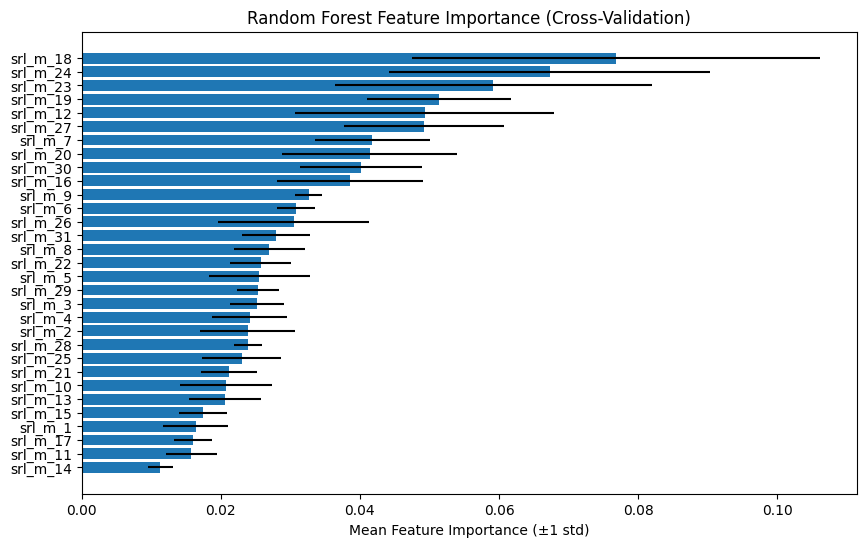

In [75]:
feature_importances = np.array(feature_importances)
mean_importance = feature_importances.mean(axis=0)
std_importance = feature_importances.std(axis=0)

feat_imp_cv = pd.DataFrame({
    "Feature": X.columns,
    "MeanImportance": mean_importance,
    "StdImportance": std_importance
}).sort_values("MeanImportance", ascending=False)

print(feat_imp_cv)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_cv["Feature"], feat_imp_cv["MeanImportance"],
         xerr=feat_imp_cv["StdImportance"])
plt.gca().invert_yaxis()
plt.xlabel("Mean Feature Importance (±1 std)")
plt.title("Random Forest Feature Importance (Cross-Validation)")
plt.show()


## Features Proxy (for f(features))

In [9]:
def pca_weighted_score(scaled_df, features):
    """
    use PCA to determine weights for given features and compute a weighted score
    """
    
    pca = PCA(n_components=1)
    pca.fit(scaled_df[features])
    
    # use absolute values of loadings as weights
    loadings = np.abs(pca.components_[0])
    weights = loadings / loadings.sum()
    
    # calculate weighted score
    scores = scaled_df[features].values @ weights
    return scores * 100, dict(zip(features, weights))

def init_states(df):
    """
    Calculate features parameters: Intrinsic, Test Anxiety, Task Value, Metacognitive
    """
    # Intrinsic proxies
    intrinsic_features = ["srl_m_1", "srl_m_2", "srl_m_3", 
                      "srl_m_4"]
    
    # Metacognitive proxies
    metacognitive_features = ["s_28", "s_29", "s_30", 
                      "s_31", "s_32", "s_33", "s_34", "s_35", "s_36"]
    
    # Task Value proxies
    task_value_features = ["srl_m_9", "srl_m_10", "srl_m_11",
                      "srl_m_12", "srl_m_13", "srl_m_14"]
    
    # Test Anxiety proxies
    test_anxiety_features = ["srl_m_27", "srl_m_28", "srl_m_29",
                      "srl_m_30", "srl_m_31"]
    
    all_features = intrinsic_features + metacognitive_features + task_value_features + test_anxiety_features
    scaler = MinMaxScaler()
    scaled_all = scaler.fit_transform(df[all_features])
    scaled_df = pd.DataFrame(scaled_all, columns=all_features, index=df.index)
    
    # pca weighted scores for each parameter
    intrinsic, intrinsic_w = pca_weighted_score(scaled_df, intrinsic_features)
    metacognitive, metacognitive_w = pca_weighted_score(scaled_df, metacognitive_features)
    task_value, task_value_w = pca_weighted_score(scaled_df, task_value_features)
    test_anxiety, test_anxiety_w = pca_weighted_score(scaled_df, test_anxiety_features)
    
    # return results and weights
    states = pd.DataFrame({
        "Intrinsic": intrinsic,
        "Metacognitive": metacognitive,
        "Task_value": task_value,
        "Test_anxiety": test_anxiety
    }, index=df.index)
    
    weights = {
        "Intrinsic": intrinsic_w,
        "Metacognitive": metacognitive_w,
        "Task_value": task_value_w,
        "Test_anxiety": test_anxiety_w
    }
    
    return states, weights

## Nudging Iteration

### With double For-loop

In [10]:
def nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    
    for t in range(n_rounds):
        # baseline prediction with CV
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        all_preds = np.zeros(len(current_y))
        rmses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = current_y.iloc[train_idx], current_y.iloc[val_idx]

            rf = RandomForestRegressor(n_estimators=200, random_state=42)
            rf.fit(X_train, y_train)

            y_pred_val = rf.predict(X_val)
            all_preds[val_idx] = y_pred_val

            # RMSE
            mse = mean_squared_error(y_val, y_pred_val)
            rmses.append(np.sqrt(mse))

        residuals = current_y.values - all_preds
        sigma = np.std(residuals)
        mean_rmse = np.mean(rmses)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Intrinsic": X_states["Intrinsic"].values,
        "Metacognitive": X_states["Metacognitive"].values,
        "Task_value": X_states["Task_value"].values,
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        f_centered = f_values - f_values.mean()
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        current_y = pd.Series(nudge_rating, index=y.index)

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })
        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        # save the final model if needed
        final_model = RandomForestRegressor(n_estimators=200, random_state=42)
        final_model.fit(X, current_y)

    return results, current_y, final_model

### With cross-val-predict

In [11]:
def nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    pred_history = []
    individual = []
    f_values_his = []
    nudged_history = []
    f_values_baseline = None
    
    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=n_splits)
        pred_history.append(all_preds.copy())
        
        
        # CV RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)


        residuals = current_y.values - all_preds
        sigma = np.std(residuals)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Intrinsic": X_states["Intrinsic"].values,
        "Metacognitive": X_states["Metacognitive"].values,
        "Task_value": X_states["Task_value"].values,
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        if f_values_baseline is None:
            f_values_baseline = f_values.copy()
        f_centered = f_values - f_values.mean()
        f_values_his.append(f_values.copy())
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N

        current_y = pd.Series(nudge_rating, index=y.index)
        nudged_history.append(current_y.copy())
        individual.append(current_y[0].copy())

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })

        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values_baseline[sort_idx], y.iloc[sort_idx], color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], color="blue", alpha=0.5, label=f"Prediction (round {t+1})")
            # plt.scatter(f_values[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            # plt.plot(f_values[sort_idx], all_preds[sort_idx], "k-", linewidth=2, label="Prediction line")
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"Nudging Iteration {t+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, y, final_model, f_values_his, pred_history, nudged_history, individual

## Iteration

In [12]:
# initialization
test_agents = X.copy()
states, weights = init_states(test_agents)
X_states = states[["Intrinsic", "Metacognitive", "Task_value", "Test_anxiety"]]

# 5 iterations
results, nudged_y, final_model, f_values_his,  pred_history, nudged_history, individual = nudging_iteration(X, y, X_states, n_rounds=20, n_splits=5, plot_each_round=False)

[Round 1] CV RMSE=10.2902, mean nudged_y=82.359, dist to preds=7.1245
[Round 2] CV RMSE=10.1999, mean nudged_y=81.372, dist to preds=6.7102
[Round 3] CV RMSE=8.7951, mean nudged_y=80.477, dist to preds=5.9584
[Round 4] CV RMSE=7.9186, mean nudged_y=80.614, dist to preds=5.2666
[Round 5] CV RMSE=7.1595, mean nudged_y=80.834, dist to preds=4.8008
[Round 6] CV RMSE=6.1226, mean nudged_y=79.941, dist to preds=4.2730
[Round 7] CV RMSE=5.5184, mean nudged_y=80.421, dist to preds=3.8154
[Round 8] CV RMSE=5.3529, mean nudged_y=81.260, dist to preds=3.8752
[Round 9] CV RMSE=5.3934, mean nudged_y=81.113, dist to preds=3.6148
[Round 10] CV RMSE=4.7027, mean nudged_y=80.696, dist to preds=3.1484
[Round 11] CV RMSE=4.1567, mean nudged_y=80.598, dist to preds=3.0397
[Round 12] CV RMSE=4.2125, mean nudged_y=81.073, dist to preds=2.7723
[Round 13] CV RMSE=3.7797, mean nudged_y=81.110, dist to preds=2.7776
[Round 14] CV RMSE=3.8047, mean nudged_y=80.862, dist to preds=2.6021
[Round 15] CV RMSE=3.3794, 

In [158]:
def no_nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Baseline simulation without nudging (y is fixed).
    - X: Training features
    - y: ground truth labels
    - X_states: DataFrame with Skill, Motivation, Fatigue
    """
    results = []
    pred_history = []
    f_values_his = []

    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, y, cv=n_splits)
        pred_history.append(all_preds.copy())

        # CV RMSE
        mse = mean_squared_error(y, all_preds)
        mean_rmse = np.sqrt(mse)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Intrinsic": X_states["Intrinsic"].values,
        "Metacognitive": X_states["Metacognitive"].values,
        "Task_value": X_states["Task_value"].values,
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, y)

        f_values = reg.predict(X_fit)
        f_values_his.append(f_values.copy())

        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_y": y.mean(),
            "mean_preds": all_preds.mean()
        })

        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean y={y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(y - all_preds)):.4f}")

        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values[sort_idx], y.iloc[sort_idx], 
                        color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], 
                        color="blue", alpha=0.5, label=f"Prediction")
            # plt.plot(f_values[sort_idx], f_values[sort_idx], "k--", label="f_value baseline")  
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"No-Nudging")
            plt.legend()
            plt.grid(True)
            plt.show()

    # save the final model
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, y)

    return results, y, final_model, f_values_his, pred_history


[Round 1] CV RMSE=10.2902, mean y=83.892, dist to preds=7.7500


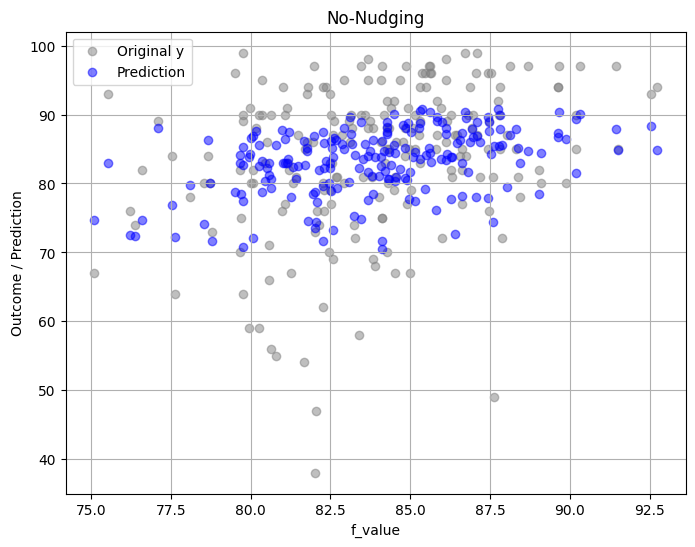

In [159]:
results_non, y_non, final_model_non, f_values_his_non, pred_history_non = no_nudging_iteration(X, y,X_states, n_rounds=1, n_splits=5, plot_each_round=True)

In [13]:
individual

[np.float64(75.32055654323702),
 np.float64(79.26812465870648),
 np.float64(76.62801006030473),
 np.float64(76.86772209438782),
 np.float64(94.8659882801158),
 np.float64(90.91212125567145),
 np.float64(90.19636764966816),
 np.float64(88.67680321632909),
 np.float64(88.01456617899971),
 np.float64(79.77639170814705),
 np.float64(84.17391957103098),
 np.float64(78.87852053776238),
 np.float64(82.01622342930224),
 np.float64(80.75798865082686),
 np.float64(79.97470566386757),
 np.float64(75.90357530266368),
 np.float64(76.4173228726642),
 np.float64(76.49437373223348),
 np.float64(76.5508741726414),
 np.float64(79.65394686373413)]

In [14]:
results = pd.DataFrame(results)
results['true_mean'] = y.mean()
results

,round,cv_rmse,mean_dist_nudge,mean_dist_true,mean_current_y,mean_all_preds,true_mean
0,1,10.290201,7.124522,7.749951,82.358586,83.164804,83.892157
1,2,10.199870,6.710155,7.736132,81.371517,82.547428,83.892157
2,3,8.795112,5.958426,7.993995,80.477206,81.461999,83.892157
3,4,7.918596,5.266646,8.620795,80.614259,80.733375,83.892157
4,5,7.159536,4.800793,8.947595,80.833868,80.603158,83.892157
5,6,6.122624,4.272996,8.980052,79.940662,80.891193,83.892157
6,7,5.518371,3.815350,9.092754,80.420527,80.123613,83.892157
7,8,5.352868,3.875228,8.903613,81.260407,80.627122,83.892157
8,9,5.393407,3.614807,8.671578,81.113235,81.153279,83.892157
9,10,4.702695,3.148402,8.550778,80.695706,81.140920,83.892157


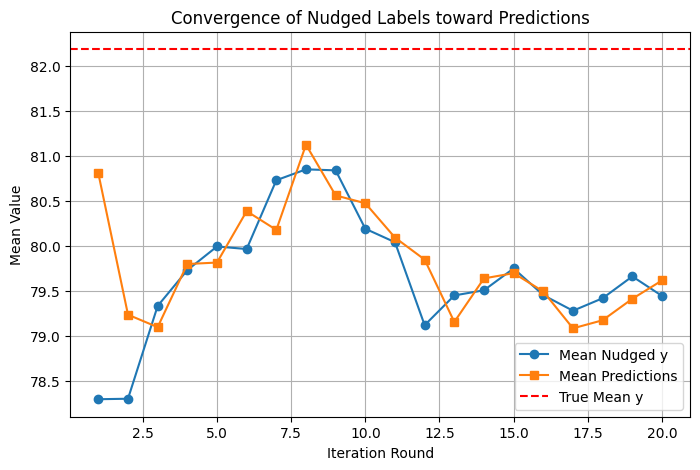

In [125]:
plt.figure(figsize=(8,5))
plt.plot(results["round"], results["mean_current_y"], marker="o", label="Mean Nudged y")
plt.plot(results["round"], results["mean_all_preds"], marker="s", label="Mean Predictions")
plt.axhline(y=results['true_mean'].iloc[0], color='r', linestyle='--', label="True Mean y")

plt.xlabel("Iteration Round")
plt.ylabel("Mean Value")
plt.title("Convergence of Nudged Labels toward Predictions")
plt.legend()
plt.grid(True)
plt.show()

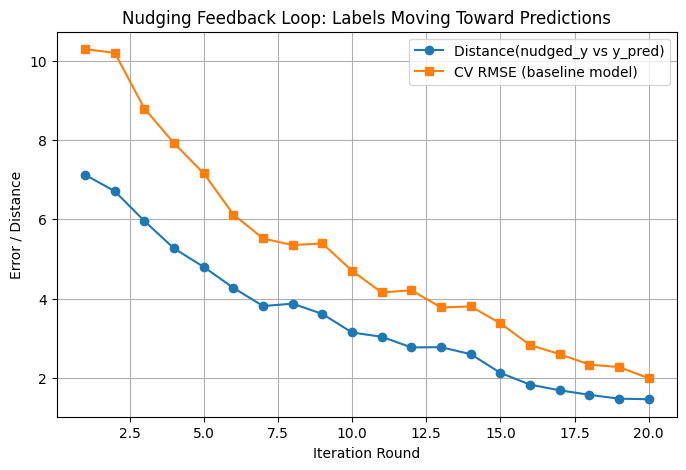

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.plot(df_results["round"], df_results["mean_dist_nudge"], marker="o", label="Distance(nudged_y vs y_pred)")
plt.plot(df_results["round"], df_results["cv_rmse"], marker="s", label="CV RMSE (baseline model)")

plt.xlabel("Iteration Round")
plt.ylabel("Error / Distance")
plt.title("Nudging Feedback Loop: Labels Moving Toward Predictions")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_nudging(y, nudged_history, pred_history, f_values_his, save_path=None):
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # calculate global ranges across all frames
    all_fvals = np.concatenate([np.asarray(f).ravel() for f in f_values_his])
    all_y_values = np.concatenate([np.asarray(y).ravel(), 
                                   np.concatenate([np.asarray(p).ravel() for p in pred_history]),
                                   np.concatenate([np.asarray(n).ravel() for n in nudged_history])])
    
    ax.set_xlim(1,100)
    ax.set_ylim(1, 100)

    fvals_baseline = np.asarray(f_values_his[0]).ravel()
    scat_true = ax.scatter(f_values_his[0], y, color="grey", alpha=0.5, label="Original y")
    scat_nudge = ax.scatter(f_values_his[0], nudged_history[0], color="red", alpha=0.5, label="Nudged y")
    scat_pred = ax.scatter(f_values_his[0], pred_history[0], color="blue", alpha=0.5, label="Prediction")
    ax.legend()

    ax.set_xlabel("f_value")
    ax.set_ylabel("Score")   

    def update(frame):
        ax.set_title(f"Nudging Iteration {frame+1}")
        preds = np.asarray(pred_history[frame]).ravel()
        nudged = np.asarray(nudged_history[frame]).ravel()
        f_vals = np.asarray(f_values_his[frame]).ravel()
        
        offsets_true = np.c_[fvals_baseline, np.asarray(y).ravel()]
        offsets_pred = np.c_[f_vals, preds]
        offsets_nudge = np.c_[f_vals, nudged]
                
        scat_true.set_offsets(offsets_true)
        scat_pred.set_offsets(offsets_pred)
        scat_nudge.set_offsets(offsets_nudge)
        return scat_true, scat_pred, scat_nudge
    ani = animation.FuncAnimation(fig, update, len(nudged_history), interval=1000, blit=True)
    if save_path:
        ani.save(save_path, writer="pillow" if save_path.endswith(".gif") else "ffmpeg")
    else:
        plt.show()


KeyError: 0

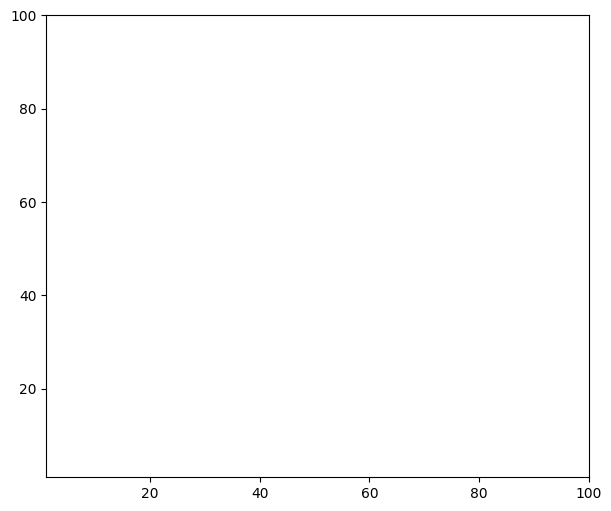

In [ ]:
animate_nudging(y, nudged_history, pred_history, f_values_his, save_path="nudging_LBLS467.gif")

In [101]:
len(nudged_y)

204

In [113]:
nudged_history[2].head()

0    78.373917
1    86.128553
2    66.142857
3    80.001218
4    94.980409
Name: score, dtype: float64

In [110]:
y.head()

0    72
1    94
2    64
3    75
4    67
Name: score, dtype: int64

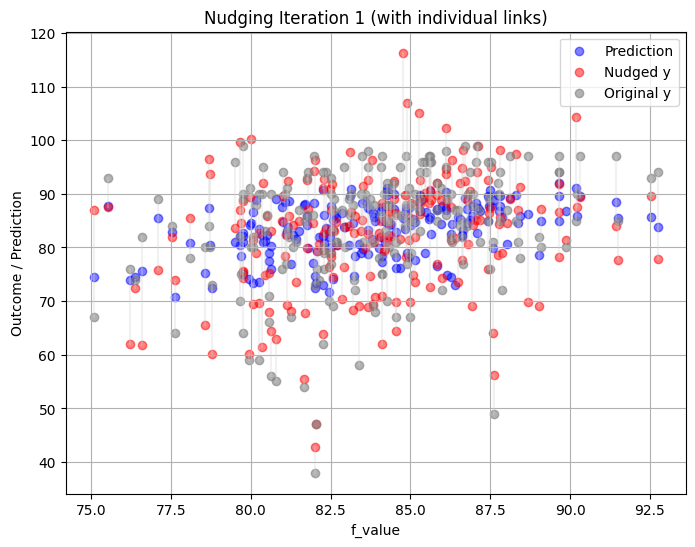

In [117]:
import matplotlib.pyplot as plt

# 假設你已經有以下變數：
# f_values, y, all_preds, nudged_y
plt.figure(figsize=(8,6))
t = 0
# 為每個樣本畫一條連線（從原始y到nudged y）
for i in range(len(y)):
    plt.plot([f_values_his[t][i], f_values_his[t][i]], [y[i], nudged_history[t][i]], color='lightgray', alpha=0.3)

# 再畫上三種點
# plt.scatter(f_values_his[t], y, color='grey', alpha=0.6, label='Original y')
plt.scatter(f_values_his[t], all_preds, color='blue', alpha=0.5, label='Prediction')
plt.scatter(f_values_his[t], nudged_history[t], color='red', alpha=0.5, label='Nudged y')
plt.scatter(f_values_his[t], y, color='grey', alpha=0.6, label='Original y')

plt.xlabel("f_value")
plt.ylabel("Outcome / Prediction")
plt.title("Nudging Iteration 1 (with individual links)")
plt.legend()
plt.grid(True)
plt.show()


## Few Individual

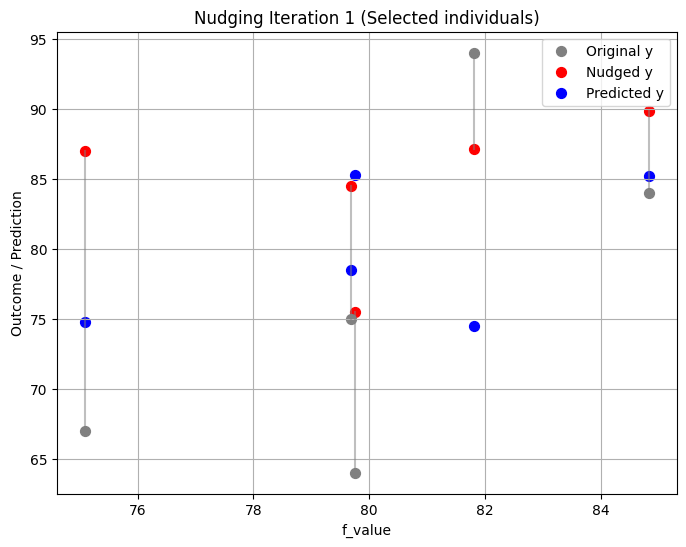

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
t = 0  # iteration
selected_idx = [1, 2, 3, 4, 5]  

# connected（original y → nudged y）
for i in selected_idx:
    plt.plot([f_values_his[t][i], f_values_his[t][i]],
             [y[i], nudged_history[t][i]],
             color='gray', alpha=0.5, linewidth=1.5)
    
    plt.scatter(f_values_his[t][i], y[i], color='grey', s=50, label='Original y' if i == selected_idx[0] else "")
    plt.scatter(f_values_his[t][i], nudged_history[t][i], color='red', s=50, label='Nudged y' if i == selected_idx[0] else "")
    plt.scatter(f_values_his[t][i], pred_history[t][i], color='blue', s=50, label='Predicted y' if i == selected_idx[0] else "")

plt.xlabel("f_value")
plt.ylabel("Outcome / Prediction")
plt.title(f"Nudging Iteration {t+1} (Selected individuals)")
plt.legend()
plt.grid(True)
plt.show()


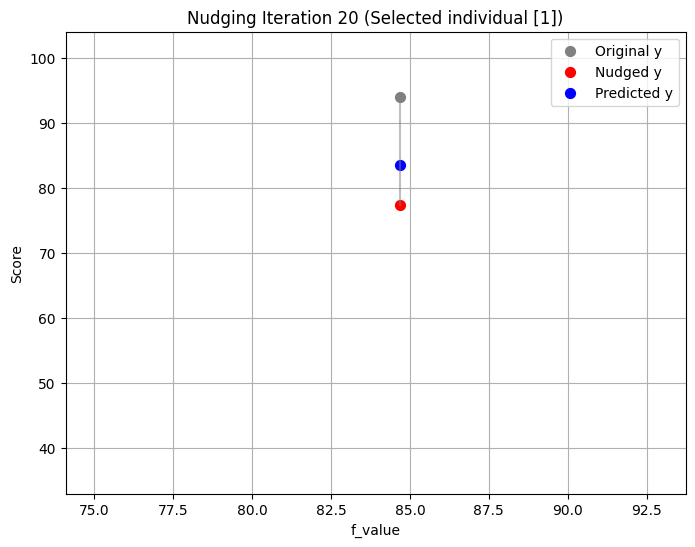

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

selected_idx = [1]  

fig, ax = plt.subplots(figsize=(8,6))
x_min = min([min(f) for f in f_values_his]) - 1
x_max = max([max(f) for f in f_values_his]) + 1
y_min = min(y) - 5
y_max = max(y) + 5

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

def update(t):
    ax.clear()  
    for i in selected_idx:
        ax.plot([f_values_his[t][i], f_values_his[t][i]],
                [y[i], nudged_history[t][i]],
                color='gray', alpha=0.5, linewidth=1.5)
        
        ax.scatter(f_values_his[t][i], y[i], color='grey', s=50, label='Original y' if i == selected_idx[0] else "")
        ax.scatter(f_values_his[t][i], nudged_history[t][i], color='red', s=50, label='Nudged y' if i == selected_idx[0] else "")
        ax.scatter(f_values_his[t][i], pred_history[t][i], color='blue', s=50, label='Predicted y' if i == selected_idx[0] else "")

    ax.set_xlabel("f_value")
    ax.set_ylabel("Score")
    ax.set_title(f"Nudging Iteration {t+1} (Selected individual [1])")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    return ax

ani = animation.FuncAnimation(fig, update, frames=20, interval=700, repeat=True)
ani.save("nudging_animation.gif", writer="pillow", fps=1)

plt.show()

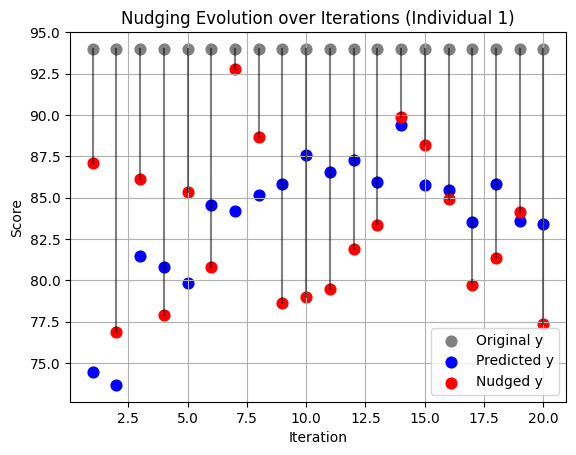

In [153]:
import matplotlib.pyplot as plt

selected_idx = 1  
n_rounds = len(pred_history)
x_iter = range(1, n_rounds + 1)

# individual scores in prediction, nudged, original over iterations
orig_score = [y[selected_idx]] * n_rounds
pred_scores = [pred_history[t][selected_idx] for t in range(n_rounds)]
nudged_scores = [nudged_history[t][selected_idx] for t in range(n_rounds)]

for t in range(n_rounds):
    plt.plot([x_iter[t], x_iter[t]], [orig_score[t], nudged_scores[t]],
             color='black', alpha=0.5, linewidth=1.5)
    
# 繪圖
plt.scatter(x_iter, orig_score, color='grey', s=60, label='Original y')
plt.scatter(x_iter, pred_scores, color='blue', s=60, label='Predicted y')
plt.scatter(x_iter, nudged_scores, color='red', s=60, label='Nudged y')

plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title(f"Nudging Evolution over Iterations (Individual {selected_idx})")
plt.legend()
plt.grid(True)
plt.show()
